In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

In [42]:
class MABEnv:
    def __init__(self, num_actions: int):
        self.num_actions = num_actions
        self.actions = np.ndarray(num_actions)
        self.reset()
        
    def reset(self):
        self.rewards = np.random.standard_normal(size=self.num_actions)

    def get_actions(self) -> np.ndarray:
        return self.actions

    def get_rewards(self) -> np.ndarray:
        return self.rewards

    def perform_action(self, action_id: int, size=1) -> float:
        return np.random.normal(loc=self.rewards[action_id], scale=1, size=size)[0]

In [43]:
class DummyEstimator:
    def __init__(self, env):
        self.reward_estimates = np.full_like(env.get_actions(), fill_value=1)

    def reset(self):
        pass

    def learn_reward(self, action_id: int, reward: float) -> None:
        pass
    
    def get_rewards(self) -> np.ndarray:
        return self.reward_estimates

In [44]:
class OracleEstimator:
    def __init__(self, env):
        self.env = env

    def reset(self):
        pass

    def learn_reward(self, action_id: int, reward: float) -> None:
        pass
    
    def get_rewards(self) -> np.ndarray:
        return self.env.get_rewards()

In [45]:
class RunningMeanEstimator:
    def __init__(self, env, prior: float = 0):
        self.env = env
        self.prior = prior
        self.reset()

    def reset(self):
        self.reward_counts = np.full_like(self.env.get_actions(), fill_value=0)
        self.reward_estimates = np.full_like(self.env.get_actions(), fill_value=self.prior)

    def learn_reward(self, action_id: int, reward: float) -> None:
        self.reward_counts[action_id] += 1
        self.reward_estimates[action_id] += (reward - self.reward_estimates[action_id]) / self.reward_counts[action_id]

    def get_rewards(self) -> np.ndarray:
        return self.reward_estimates

In [46]:
class RandomSelectionRule:
    def pick_action(self, env, estimator):
        return random.randint(0, len(estimator.get_rewards())-1)

In [8]:
class EpsilonGreedySelectionRule:
    def __init__(self, eps: float = 0.0):
        self.eps = eps

    def pick_action(self, env, estimator):
        if random.random() >= self.eps:
            return estimator.get_rewards().argmax()
        else:
            return random.randint(0, len(env.get_rewards())-1)

In [9]:
def simulate(env, estimator, rule, steps):
    estimator.reset()
    rewards = []
    picked_actions = []
    optimal_actions = []
    for step in range(steps):
        action_id = rule.pick_action(env, estimator)
        reward = env.perform_action(action_id)
        estimator.learn_reward(action_id, reward)
        rewards.append(reward)
        picked_actions.append(action_id)
        optimal_actions.append(env.get_rewards().argmax())
    
    rewards = np.array(rewards)
    rewards = rewards.cumsum() / np.arange(1, len(rewards)+1)
    picked_actions = np.array(picked_actions)
    optimal_actions = np.array(optimal_actions)
    optimal_ratios = (picked_actions == optimal_actions).astype(int).cumsum() / np.arange(1, len(rewards)+1)

    result = {
        "step": np.arange(1, steps+1),
        "rewards": rewards,
        "optimal": optimal_ratios
    }
    return pd.DataFrame(result).set_index("step")

In [18]:
def plot_results(run_results):
    all_rewards = []
    all_optimal = []
    for run_id, run_result in enumerate(run_results, 1):
        run_rewards = pd.DataFrame({name: results["rewards"] for (name, results) in run_result.items()})
        run_optimal = pd.DataFrame({name: results["optimal"] for (name, results) in run_result.items()})
        run_rewards["run_id"] = run_id
        run_optimal["run_id"] = run_id
        all_rewards.append(run_rewards)
        all_optimal.append(run_optimal)
    all_rewards = pd.concat(all_rewards)
    all_optimal = pd.concat(all_optimal)

    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    all_rewards.groupby("step").mean().drop(columns=["run_id"]).plot(ylabel="average reward", ax = axes[0])
    all_optimal.groupby("step").mean().drop(columns=["run_id"]).plot(ylabel="optimal action rate", ax = axes[1])

### Run some tests

In [19]:
env = MABEnv(num_actions=10)

In [20]:
env.reset()
print(env.get_rewards())

[ 0.47599437 -1.30257104  0.22827772  0.42619847 -2.28327051 -0.68301379
 -1.64353325 -0.83595863  0.10716496 -0.74152136]


<Axes: xlabel='step'>

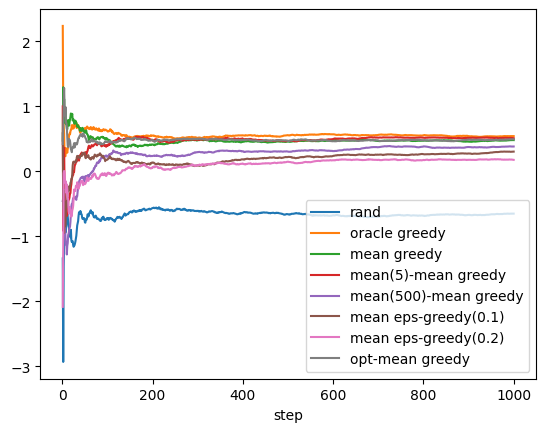

In [21]:
pd.DataFrame({
    'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=1000)["rewards"],
    'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["rewards"],
    'mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["rewards"],
    'mean(5)-mean greedy': simulate(env, RunningMeanEstimator(env, prior=5), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
    'mean(500)-mean greedy': simulate(env, RunningMeanEstimator(env, prior=500), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
    'mean eps-greedy(0.1)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.1), steps=1000)["rewards"],
    'mean eps-greedy(0.2)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.2), steps=1000)["rewards"],
    'opt-mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
}).plot()

<Axes: xlabel='step'>

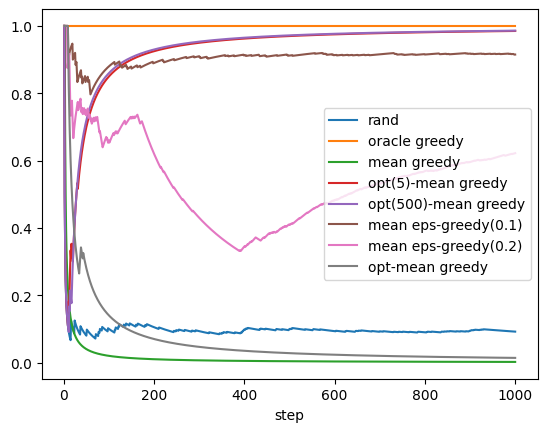

In [22]:
pd.DataFrame({
    'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=1000)["optimal"],
    'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["optimal"],
    'mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["optimal"],
    'opt(5)-mean greedy': simulate(env, RunningMeanEstimator(env, prior=5), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
    'opt(500)-mean greedy': simulate(env, RunningMeanEstimator(env, prior=500), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
    'mean eps-greedy(0.1)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.1), steps=1000)["optimal"],
    'mean eps-greedy(0.2)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.2), steps=1000)["optimal"],
    'opt-mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
}).plot()

### Compare gready & eps-greedy strategies:

In [ ]:
env.reset()
print(env.get_rewards())

In [36]:
print(env.get_rewards())

[ 0.25084635 -2.49968527  0.68066829 -0.90025625  1.96585146 -0.07701043
  1.92716266  1.65427355 -1.66928011  0.01460433]


  0%|          | 0/2000 [00:00<?, ?it/s]

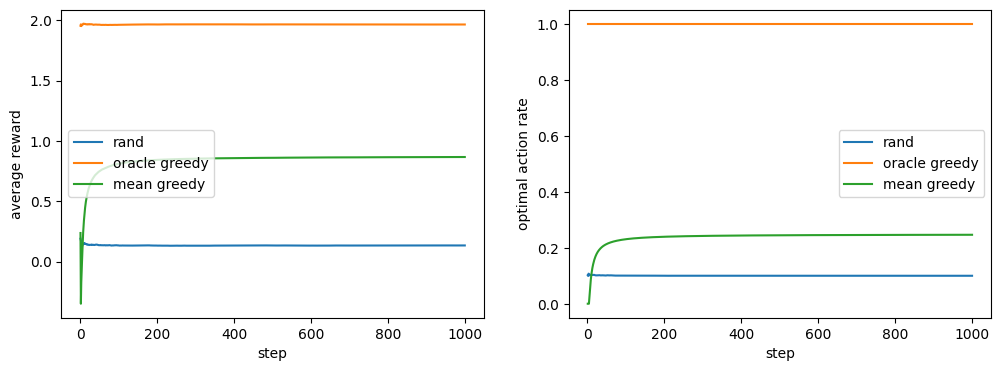

In [32]:
run_results = []
for run_id in tqdm.trange(2000):
    run_result = {
        'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=1000),
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000),
        'mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000),
    }
    run_results.append(run_result)

plot_results(run_results)

  0%|          | 0/2000 [00:00<?, ?it/s]

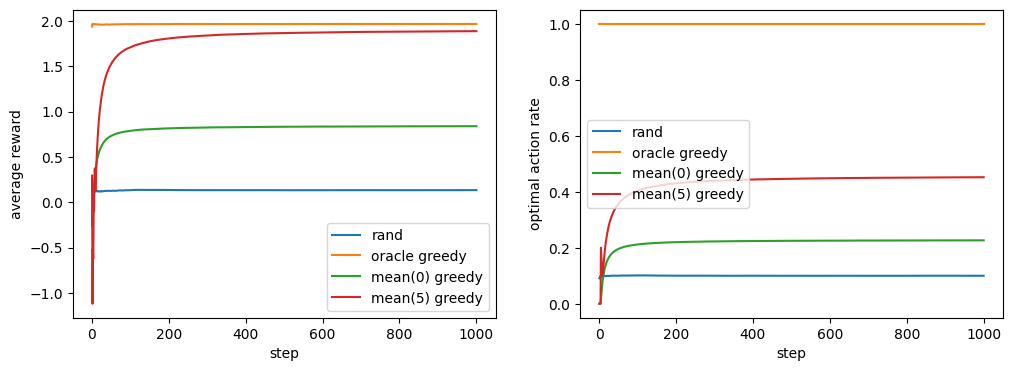

In [40]:
num_runs = 2000
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    env.reset()
    run_result = {
        'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=num_steps),
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(5) greedy': simulate(env, RunningMeanEstimator(env, prior=5), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

  0%|          | 0/2000 [00:00<?, ?it/s]

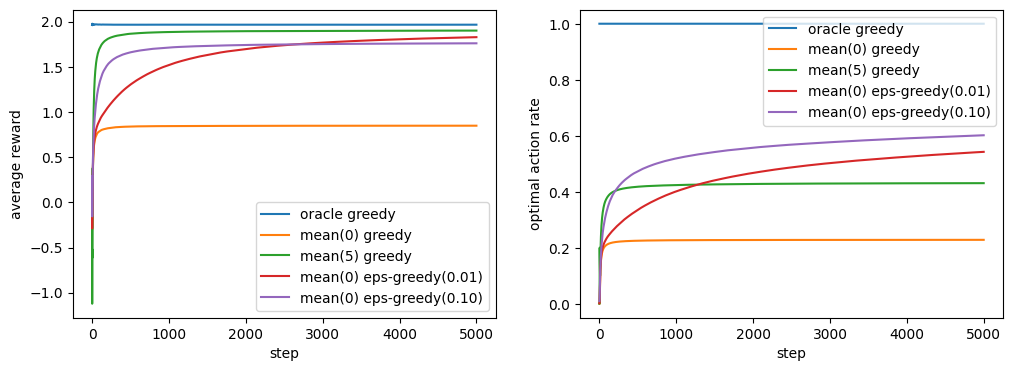

In [38]:
num_runs = 2000
num_steps = 5000

run_results = []
for run_id in tqdm.trange(num_runs):
    run_result = {
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(5) greedy': simulate(env, RunningMeanEstimator(env, prior=5), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) eps-greedy(0.01)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.01), steps=num_steps),
        'mean(0) eps-greedy(0.10)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

### Excercise 2.5.

Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation of 0.01 to all the $q_*(a)$ on each step).  

Prepare plots like Fiture 2.2 for an action-value method using sample averages, incrementally computed and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\epsilon=0.1$ and longer runs, say of 10,000 steps.

In [107]:
class NonStationaryMABEnv:
    def __init__(self, num_actions: int):
        self.num_actions = num_actions
        self.actions = np.ndarray(num_actions)
        self.reset()
        
    def reset(self):
        self.rewards = np.full(shape=self.num_actions, fill_value=1, dtype=np.float64)

    def update(self):
        self.rewards += np.random.normal(loc=0, scale=0.01, size=self.num_actions)

    def get_actions(self) -> np.ndarray:
        return self.actions

    def get_rewards(self) -> np.ndarray:
        return self.rewards

    def perform_action(self, action_id: int, size=1) -> float:
        result = np.random.normal(loc=self.rewards[action_id], scale=1, size=size)[0]
        return result

In [108]:
env = NonStationaryMABEnv(num_actions=10)

In [109]:
env.get_rewards()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [110]:
def simulate2(env, estimator, rule, steps):
    env.reset()
    estimator.reset()
    rewards = []
    picked_actions = []
    optimal_actions = []
    for step in range(steps):
        action_id = rule.pick_action(env, estimator)
        reward = env.perform_action(action_id)
        estimator.learn_reward(action_id, reward)
        rewards.append(reward)
        picked_actions.append(action_id)
        optimal_actions.append(env.get_rewards().argmax())
        env.update()
    
    rewards = np.array(rewards)
    rewards = rewards.cumsum() / np.arange(1, len(rewards)+1)
    picked_actions = np.array(picked_actions)
    optimal_actions = np.array(optimal_actions)
    optimal_ratios = (picked_actions == optimal_actions).astype(int).cumsum() / np.arange(1, len(rewards)+1)

    result = {
        "step": np.arange(1, steps+1),
        "rewards": rewards,
        "optimal": optimal_ratios
    }
    return pd.DataFrame(result).set_index("step")

  0%|          | 0/2000 [00:00<?, ?it/s]

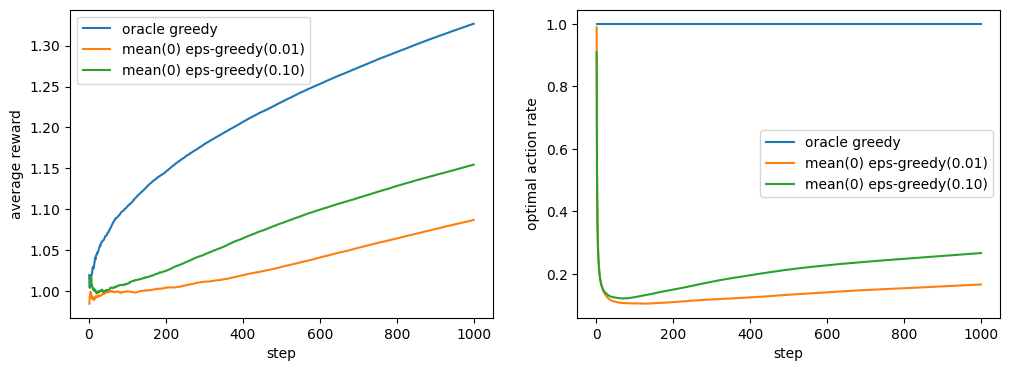

In [112]:
num_runs = 2000
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    run_result = {
        'oracle greedy': simulate2(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) eps-greedy(0.01)': simulate2(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.01), steps=num_steps),
        'mean(0) eps-greedy(0.10)': simulate2(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

In [114]:
class ExponentialRecencyWeightedAverageEstimator:
    def __init__(self, env, prior: float = 0, step = 0.1):
        self.env = env
        self.prior = prior
        self.step = step
        self.reset()

    def reset(self):
        self.reward_counts = np.full_like(self.env.get_actions(), fill_value=0)
        self.reward_estimates = np.full_like(self.env.get_actions(), fill_value=self.prior)

    def learn_reward(self, action_id: int, reward: float) -> None:
        self.reward_counts[action_id] += 1
        self.reward_estimates[action_id] += self.step * (reward - self.reward_estimates[action_id])

    def get_rewards(self) -> np.ndarray:
        return self.reward_estimates

  0%|          | 0/2000 [00:00<?, ?it/s]

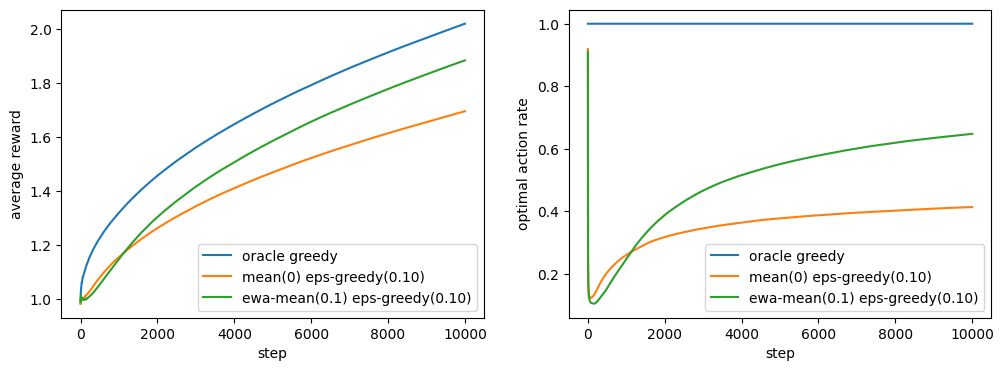

In [116]:
num_runs = 2000
num_steps = 10000

run_results = []
for run_id in tqdm.trange(num_runs):
    ## TODO: test under similar env trajectories!
    run_result = {
        'oracle greedy': simulate2(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) eps-greedy(0.10)': simulate2(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
        'ewa-mean(0.1) eps-greedy(0.10)': simulate2(env, ExponentialRecencyWeightedAverageEstimator(env, step=0.1), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)